# in this notebook:
### extract km metric for cifar100 by running k-means algorithm on the features
  - get features after running SWaV om cifar100
  - run k-means with different k value and find the best by elbow method

In [1]:
import os
import pickle
import random
import re
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torchvision
from lightly.data import (
    LightlyDataset,
    collate,
)
from scipy.spatial.distance import cdist
from sklearn import neighbors
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from yellowbrick.cluster import KElbowVisualizer

from swav_cifar import SwaVModel
from train import DIR_ROOT_SAVE
from utils import PATH_DATASETS

warnings.filterwarnings("ignore", category=UserWarning)

NUM_TRAIN = 50000
NUM_TEST = 10000
NUM_FEATURES = 512
BATCH_SIZE = 512
NUM_CLASSES = 100
path_to_train = os.path.join(PATH_DATASETS, 'cifar100images', 'train')
path_to_test = os.path.join(PATH_DATASETS, 'cifar100images', 'test')

# No additional augmentations for the test set
test_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=collate.imagenet_normalize["mean"],
            std=collate.imagenet_normalize["std"],
        ),
    ]
)

dataset_train_ssl = LightlyDataset(input_dir=path_to_train)
# we use test transformations for getting the feature for kNN on train data
dataset_train_kNN = LightlyDataset(input_dir=path_to_train, transform=test_transforms)
dataset_test = LightlyDataset(input_dir=path_to_test, transform=test_transforms)

dataloader_train_kNN = torch.utils.data.DataLoader(dataset_train_kNN, batch_size=BATCH_SIZE, shuffle=False,
                                                   drop_last=False, num_workers=4)

dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, drop_last=False,
                                              num_workers=4)

PATH_MODEL = os.path.join(DIR_ROOT_SAVE, f'swav_cifar100_{NUM_FEATURES}')
swav = SwaVModel(dataloader_train_kNN, NUM_CLASSES)
swav.load_state_dict(torch.load(os.path.join(PATH_MODEL, 'model.pt'))['model'])
swav.eval()

features = np.load(os.path.join(PATH_MODEL, 'feature.npy'))
labels = np.load(os.path.join(PATH_MODEL, 'labels.npy'))
features_test = np.load(os.path.join(PATH_MODEL, 'features_test.npy'))
labels_test = np.load(os.path.join(PATH_MODEL, 'labels_test.npy'))
idx = np.load(os.path.join(PATH_MODEL, 'idx.npy'))

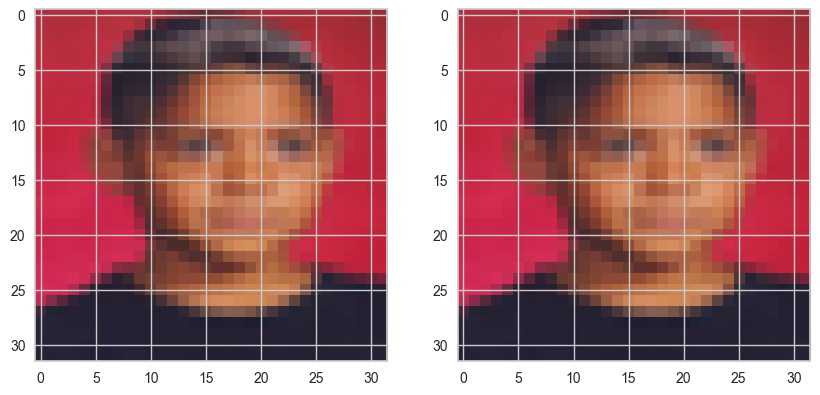

In [2]:
data1 = torchvision.datasets.CIFAR100(PATH_DATASETS, train=True, download=False)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
i = random.randint(0, NUM_TEST)
img_idx = int(re.findall(r'\d+', dataset_train_ssl[i][2])[-1])
axes[0].imshow(data1[img_idx][0])
axes[1].imshow(dataset_train_ssl[i][0])
for i in range(NUM_TRAIN):
    img_idx = int(re.findall(r'\d+', dataset_train_ssl[i][2])[-1])
    assert dataset_train_ssl[i][0] == data1[img_idx][0], i

### Projection of 512 dimensions by 2 for check that the feature can separate the classes

In [5]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3, verbose=True).fit_transform(
    features)

df = pd.DataFrame()
df["y"] = labels
df["comp-1"] = X_embedded[:, 0]
df["comp-2"] = X_embedded[:, 1]
df.to_csv(os.path.join(PATH_MODEL, 'tsne.csv'))

[t-SNE] Computing 10 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.031s...
[t-SNE] Computed neighbors for 50000 samples in 12.444s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for sa

[Text(0.5, 1.0, 'CIFAR100 dataset T-SNE projection')]

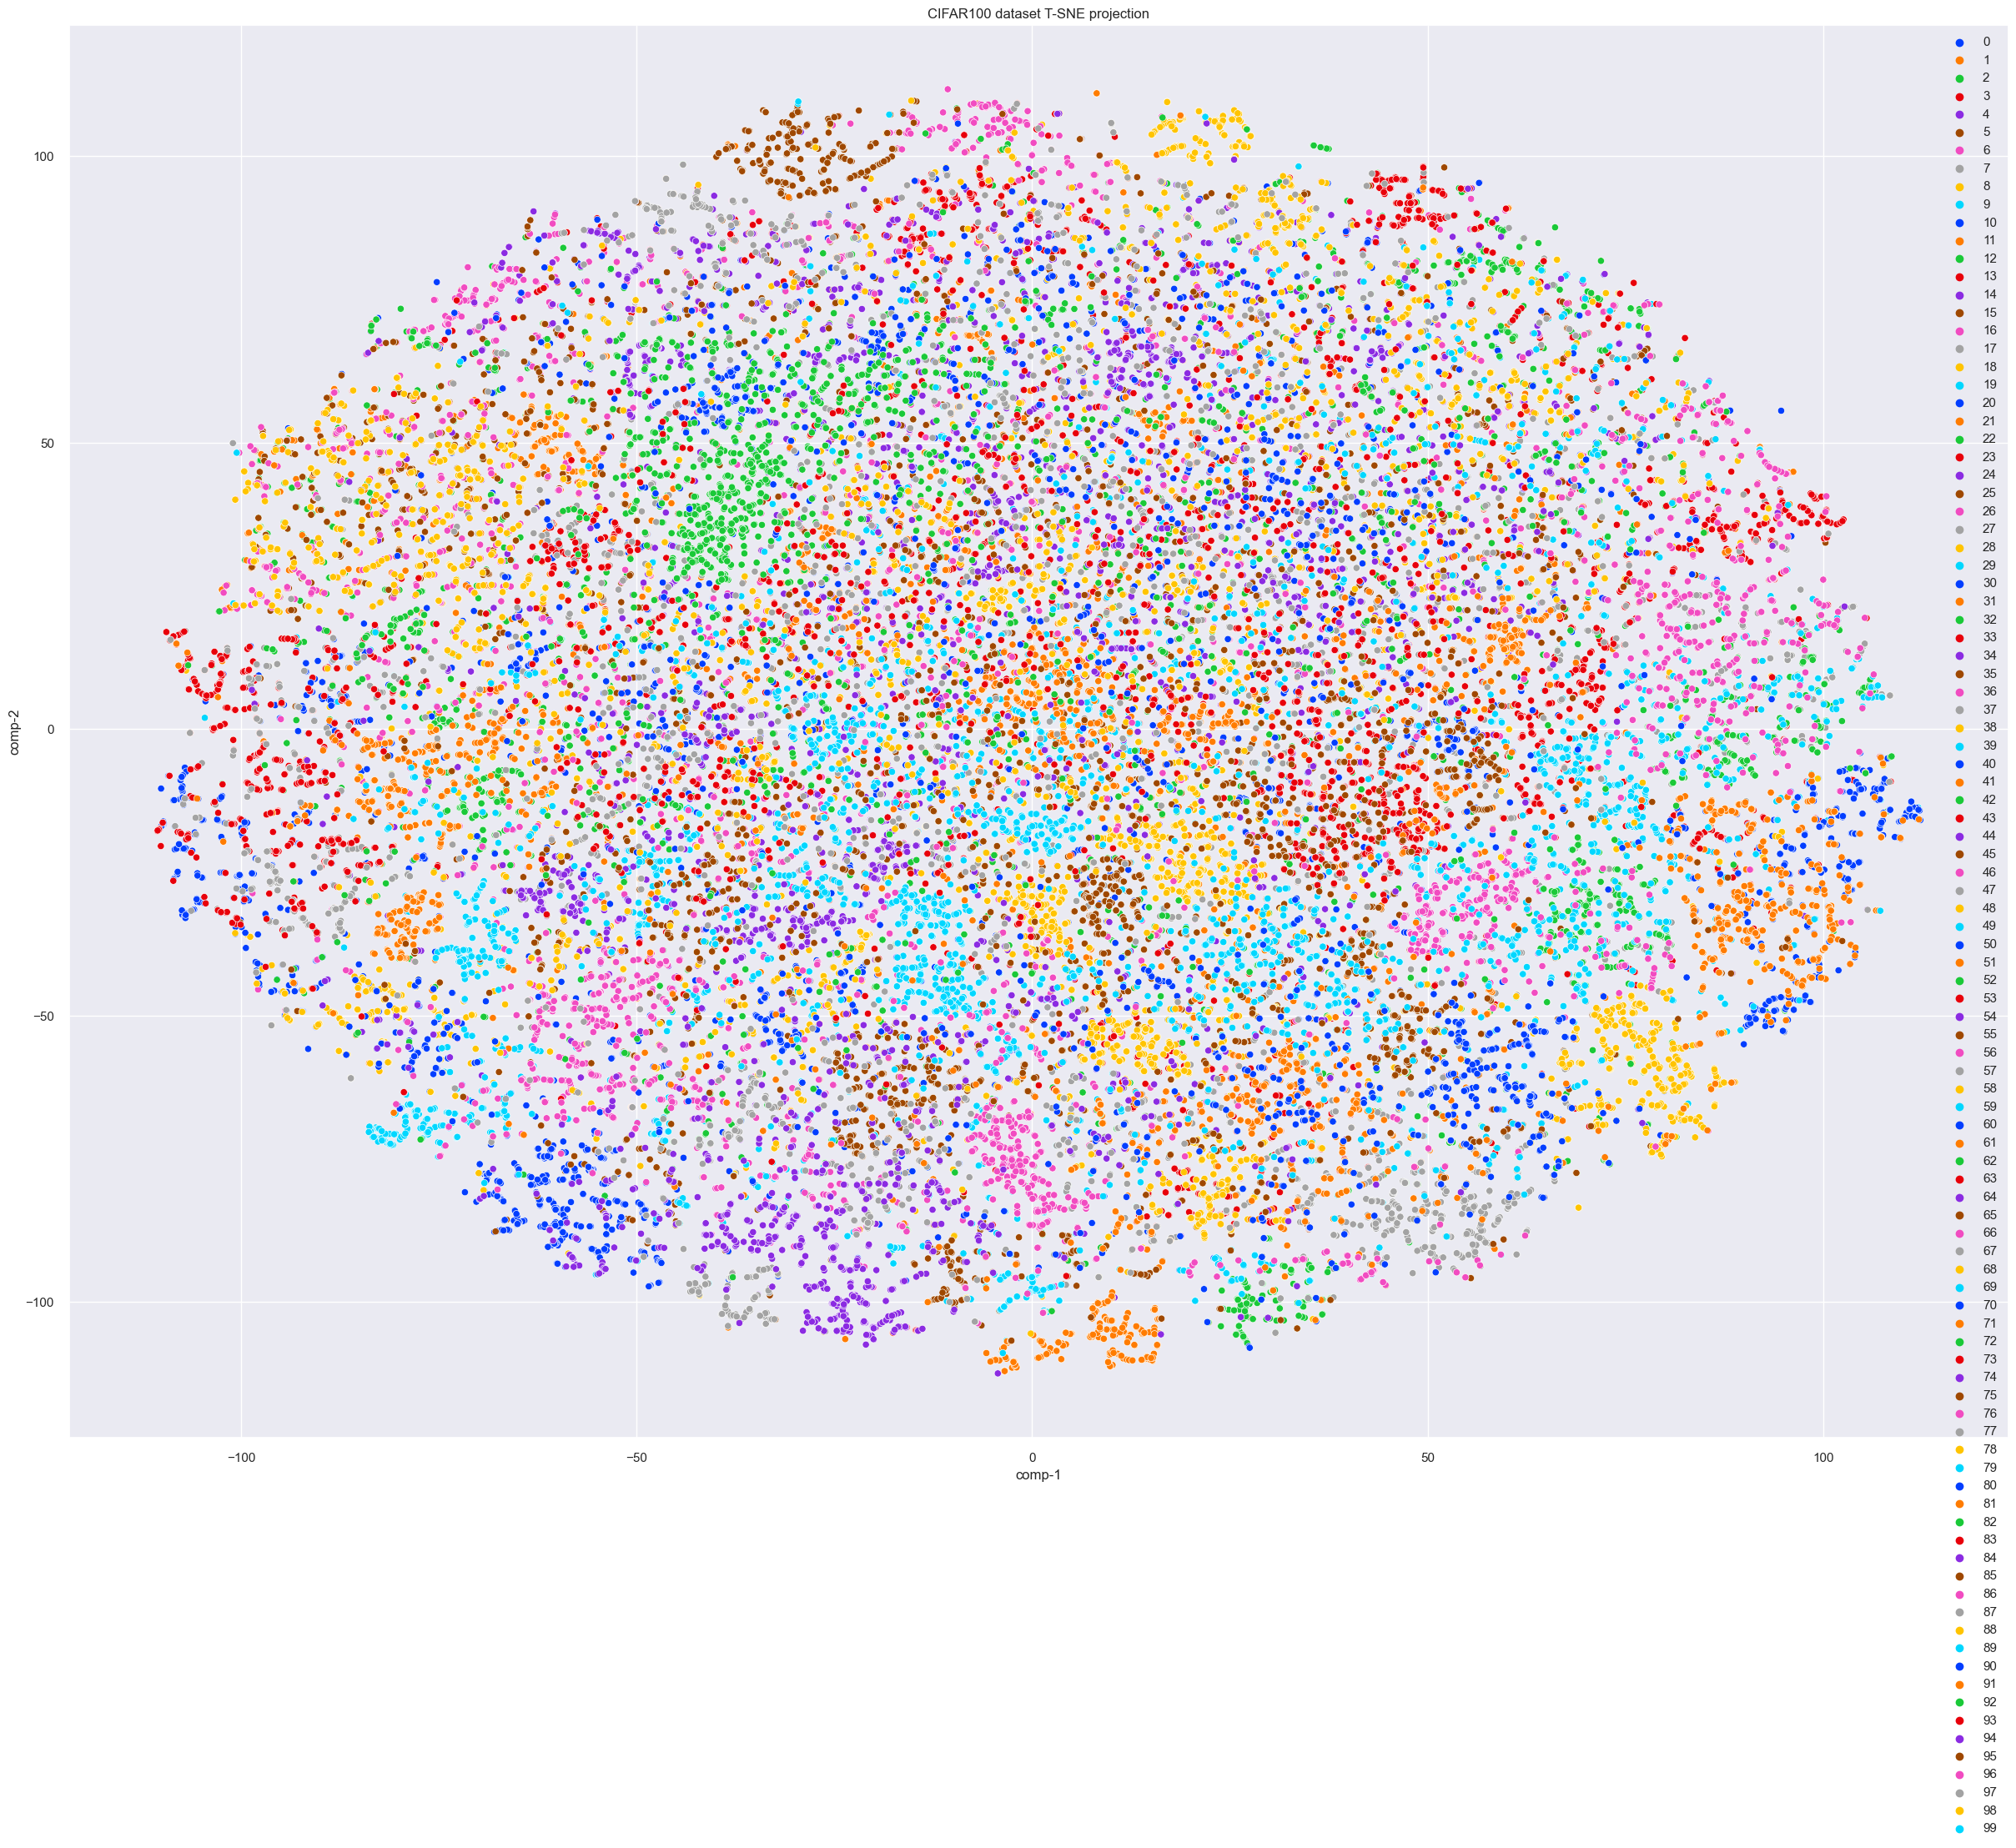

In [6]:
df = pd.read_csv(os.path.join(PATH_MODEL, 'tsne.csv'))
sns.set(rc={'figure.figsize': (30, 22)})
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("bright", 10),
                data=df).set(title="CIFAR100 dataset T-SNE projection")

In [7]:
clf = neighbors.KNeighborsClassifier(n_neighbors=20)
clf.fit(features, labels)
p = clf.predict(features)
sum(np.equal(p, labels)) / NUM_TRAIN

0.49946

In [8]:
features_test = np.empty((NUM_TEST, NUM_FEATURES))
labels_test = np.empty((NUM_TEST,), dtype=int)

n = 0
for images, label, files_names in dataloader_test:
    features_test[n:n + len(label)] = swav(images).detach().numpy()
    labels_test[n:(n := n + len(label))] = np.array(label)

sum(np.equal(clf.predict(features_test), labels_test)) / NUM_TEST
np.save(os.path.join(PATH_MODEL, 'features_test.npy'), features_test)
np.save(os.path.join(PATH_MODEL, 'labels_test.npy'), labels_test)

In [13]:
idx = np.empty(NUM_TRAIN, dtype=int)
for i, img_data in enumerate(dataset_train_ssl):
    idx[int(re.findall(r'\d+', img_data[2])[-1])] = i
np.save(os.path.join(PATH_MODEL, 'idx.npy'), idx)

C:\Users\ProjectUser\Documents\Data-pruning\models_data\swav_cifar100_512


### search the best k for elbow method, we check k in rang 1-1001

Initialization complete
Iteration 0, inertia 1450754.243271072.
Iteration 1, inertia 791244.0121573126.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1300484.3738092554.
Iteration 1, inertia 688714.6431134773.
Iteration 2, inertia 683946.8308789922.
Iteration 3, inertia 682661.1231455858.
Iteration 4, inertia 682264.7212498102.
Iteration 5, inertia 682130.9981316961.
Iteration 6, inertia 682089.8450174172.
Iteration 7, inertia 682076.6935341738.
Iteration 8, inertia 682070.8498361598.
Iteration 9, inertia 682068.642441468.
Iteration 10, inertia 682068.1682672398.
Iteration 11, inertia 682068.0025249039.
Converged at iteration 11: center shift 9.810591225064983e-07 within tolerance 3.090796922489504e-06.
Initialization complete
Iteration 0, inertia 1132118.8193618415.
Iteration 1, inertia 661045.3523785097.
Iteration 2, inertia 656593.2436677839.
Iteration 3, inertia 654707.3580288389.
Iteration 4, inertia 653246.4691713403.
Iteration 5, iner

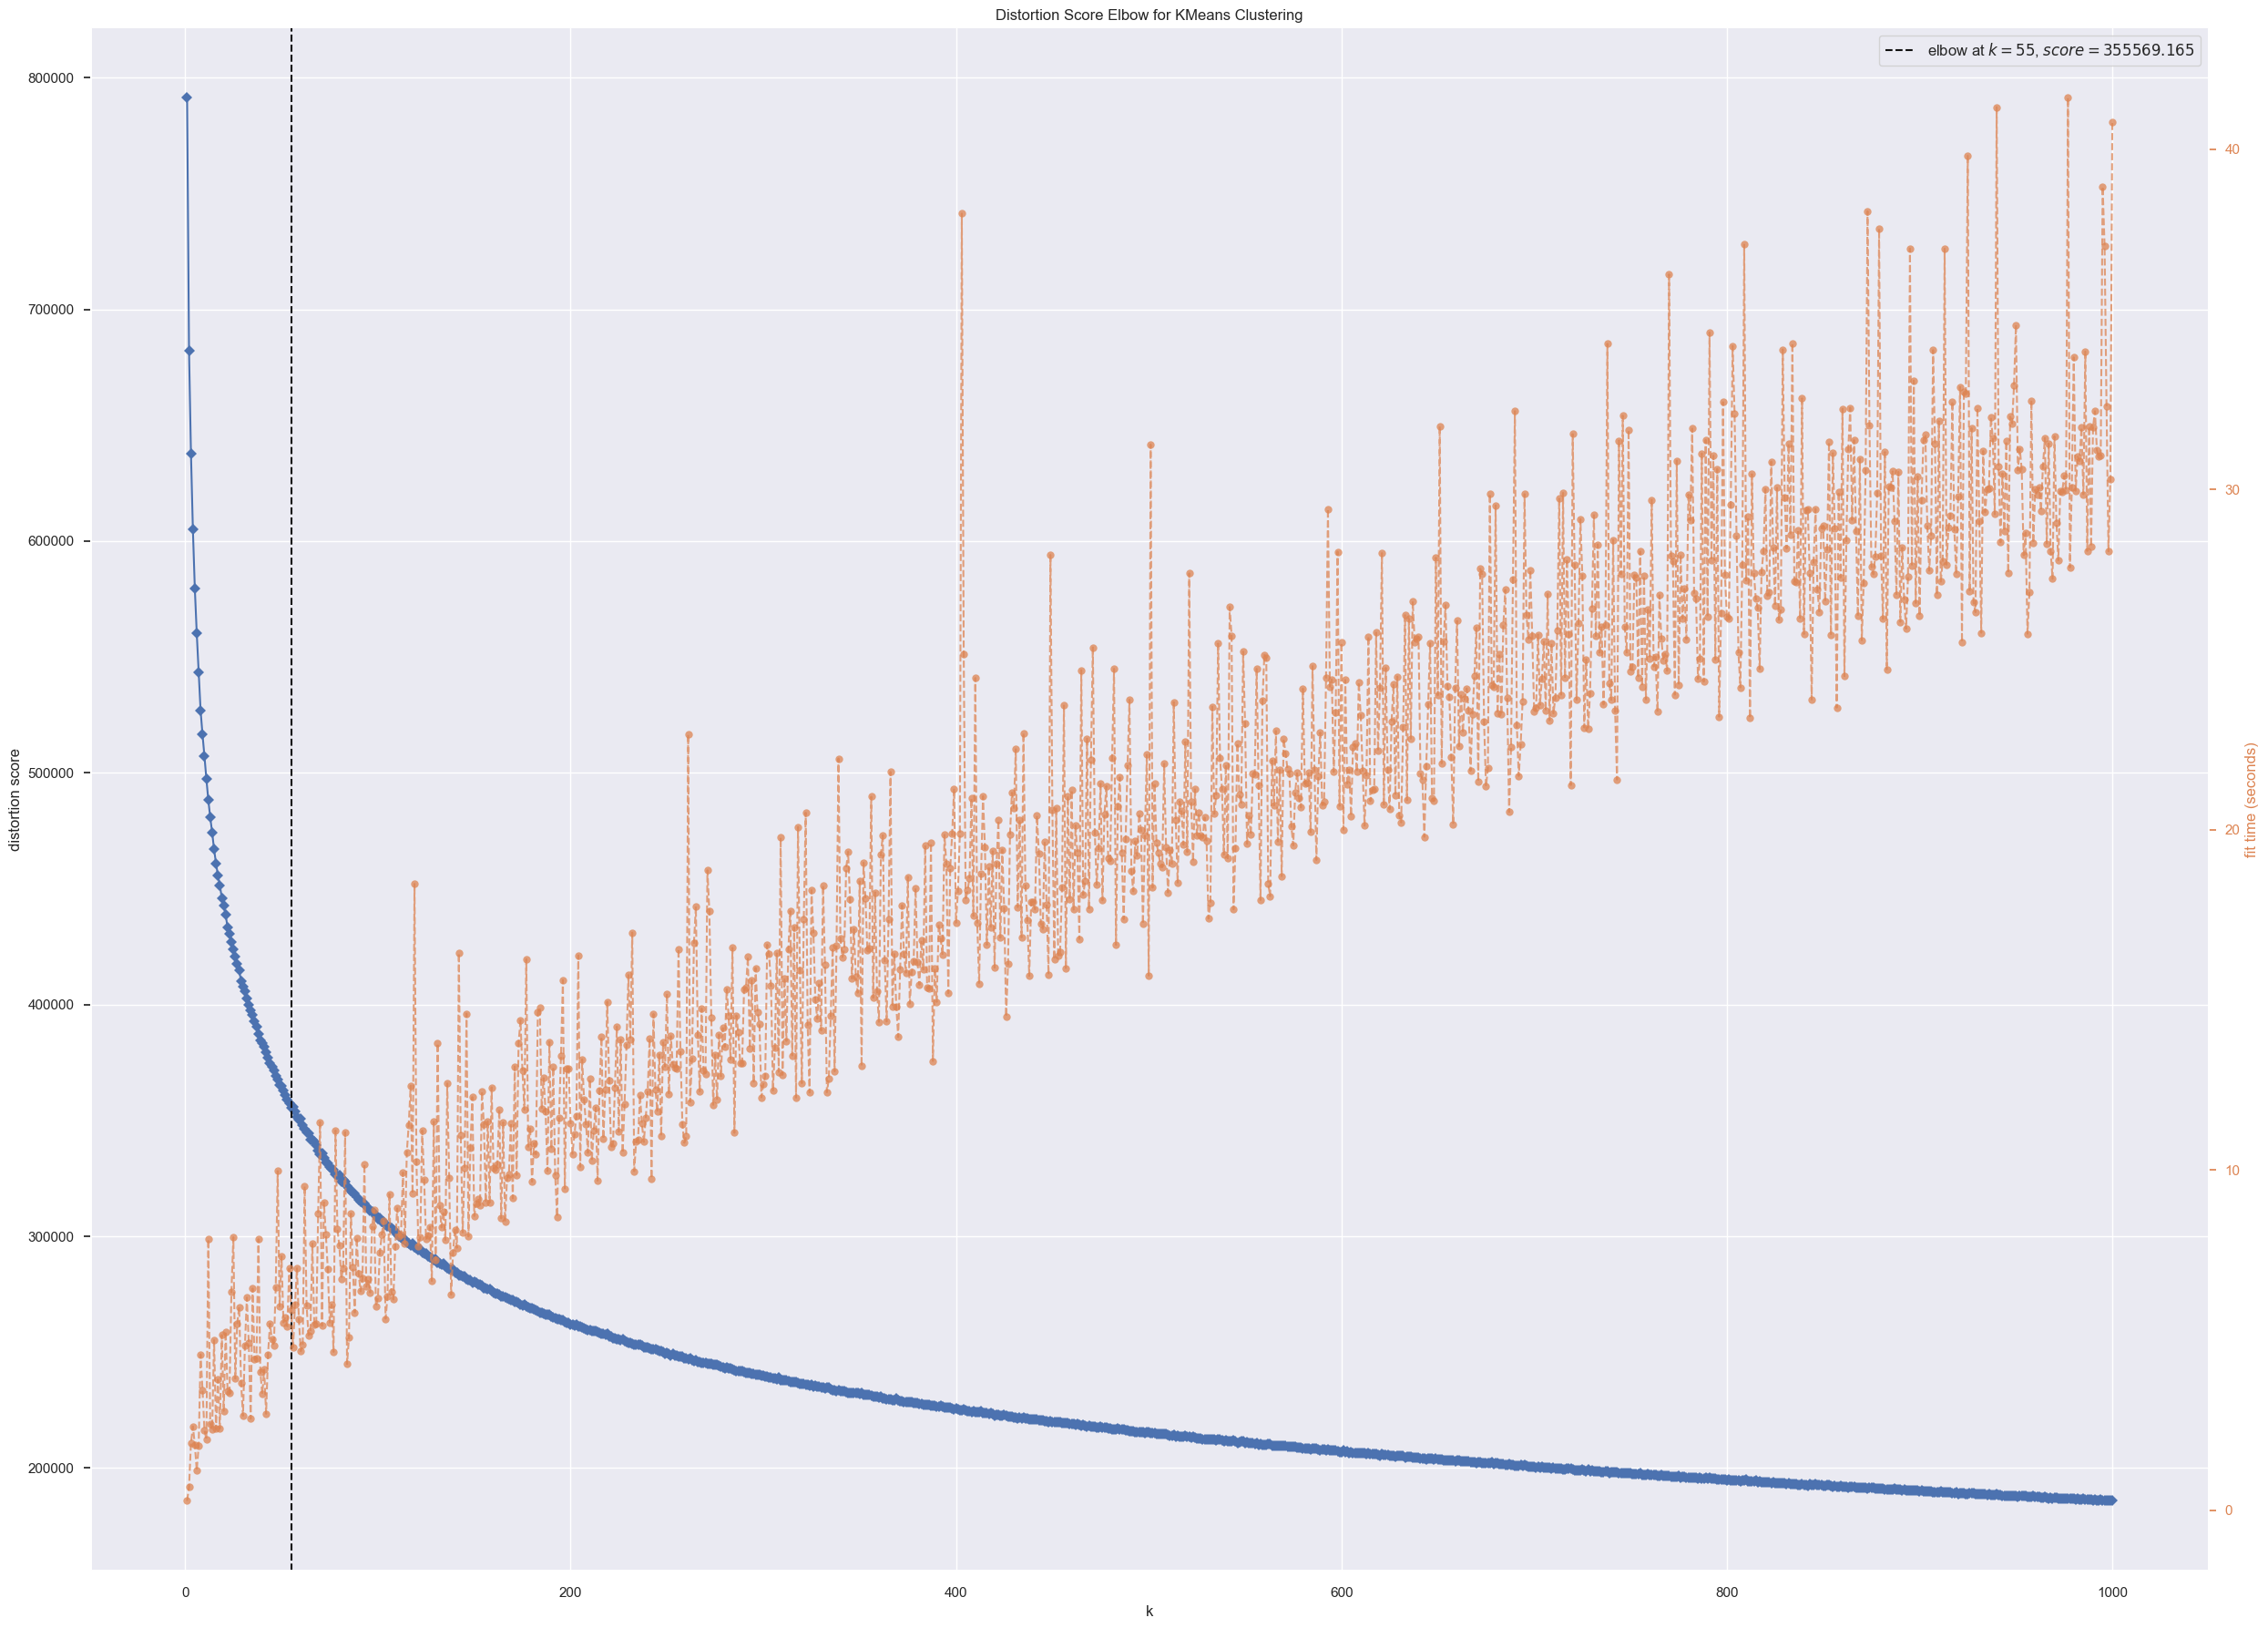

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [9]:
km = KMeans(max_iter=100000, n_init="auto", verbose=True)
visualizer = KElbowVisualizer(km, k=(1, 1001))

visualizer.fit(features)  # Fit the data to the visualizer
visualizer.show()

In [10]:
distortions = {}
inertias = {}
k_val = {}
K = range(1, 1001)
for k in K:
    # Building and fitting the model
    print(f'------------   k={k}   --------------------------')
    kMeanModel = KMeans(n_clusters=k, max_iter=100000, n_init="auto", verbose=False).fit(features)

    pred = kMeanModel.predict(features)
    m2 = kMeanModel.transform(features)
    dist_ = m2[np.arange(NUM_TRAIN), pred]
    k_val[k] = dist_

    dist = np.min(cdist(features, kMeanModel.cluster_centers_, 'euclidean'), axis=1)
    distortions[k] = np.average(dist)
    inertias[k] = kMeanModel.inertia_

with open(os.path.join(PATH_MODEL, 'all_k_1_300.npy'), 'wb') as f:
    pickle.dump([k_val, distortions, inertias], f)

------------   k=1   --------------------------
------------   k=2   --------------------------
------------   k=3   --------------------------
------------   k=4   --------------------------
------------   k=5   --------------------------
------------   k=6   --------------------------
------------   k=7   --------------------------
------------   k=8   --------------------------
------------   k=9   --------------------------
------------   k=10   --------------------------
------------   k=11   --------------------------
------------   k=12   --------------------------
------------   k=13   --------------------------
------------   k=14   --------------------------
------------   k=15   --------------------------
------------   k=16   --------------------------
------------   k=17   --------------------------
------------   k=18   --------------------------
------------   k=19   --------------------------
------------   k=20   --------------------------
------------   k=21   -------

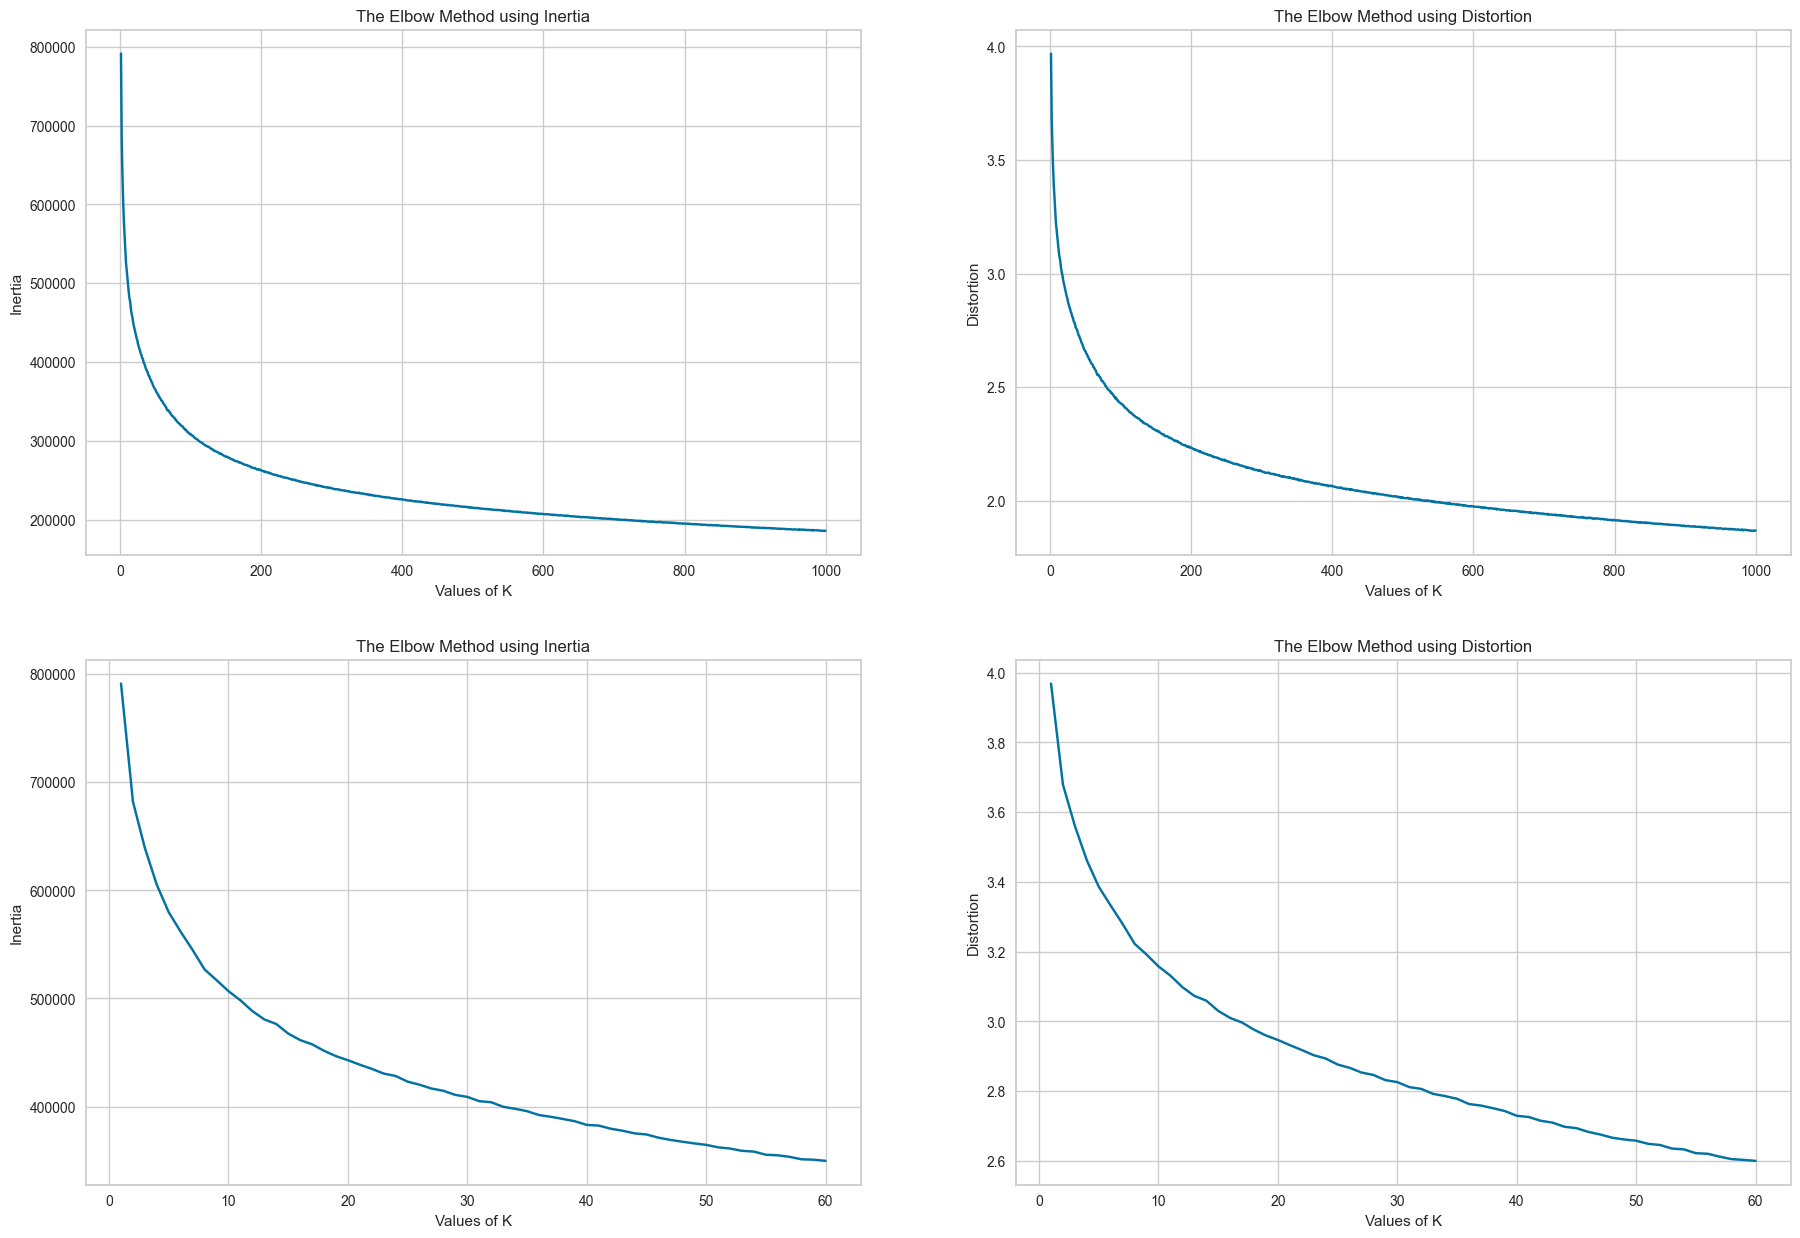

In [3]:
with open(os.path.join(PATH_MODEL, 'all_k_1_300.npy'), 'rb') as f:
    k_val, distortions, inertias = pickle.load(f)

plt.figure(figsize=(22, 15))
plt.subplot(2, 2, 1)
plt.plot([k for k in inertias.keys()], [k for k in inertias.values()], 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')

plt.subplot(2, 2, 2)
plt.plot([k for k in distortions.keys()], [k for k in distortions.values()], 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')

i, j = 0, 60
plt.subplot(2, 2, 3)
plt.plot([k for k in inertias.keys()][i:j], [k for k in inertias.values()][i:j], 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')

plt.subplot(2, 2, 4)
plt.plot([k for k in distortions.keys()][i:j], [k for k in distortions.values()][i:j], 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

### save km metric for k=55,100,200

In [11]:
k = 200
model_k_200 = KMeans(n_clusters=k, n_init=10, max_iter=100000, verbose=True).fit(features)
pred_200 = model_k_200.predict(features)
m2_200 = model_k_200.transform(features)
km_dist = m2_200[np.arange(NUM_TRAIN), pred_200][idx]
np.save(os.path.join(PATH_MODEL, 'km_dist_200.npy'), km_dist)

Initialization complete
Iteration 0, inertia 367236.8890743432.
Iteration 1, inertia 279997.33447746956.
Iteration 2, inertia 273424.4669644217.
Iteration 3, inertia 270633.37739616405.
Iteration 4, inertia 268950.0807117158.
Iteration 5, inertia 267788.00078935886.
Iteration 6, inertia 266959.6218947539.
Iteration 7, inertia 266377.79423418007.
Iteration 8, inertia 265931.61640221335.
Iteration 9, inertia 265558.9034170268.
Iteration 10, inertia 265247.2832842569.
Iteration 11, inertia 265000.3270144818.
Iteration 12, inertia 264769.1081825542.
Iteration 13, inertia 264568.2652058375.
Iteration 14, inertia 264403.4886258995.
Iteration 15, inertia 264267.67042148544.
Iteration 16, inertia 264146.215205723.
Iteration 17, inertia 264037.6828943261.
Iteration 18, inertia 263935.3179003025.
Iteration 19, inertia 263845.4366527388.
Iteration 20, inertia 263766.9970672863.
Iteration 21, inertia 263699.6271747951.
Iteration 22, inertia 263639.7238931255.
Iteration 23, inertia 263586.279279651

In [10]:
k = 100
model_k_100 = KMeans(n_clusters=k, n_init=10, max_iter=100000, verbose=True).fit(features)
pred_100 = model_k_100.predict(features)
m2_100 = model_k_100.transform(features)
km_dist = m2_100[np.arange(NUM_TRAIN), pred_100][idx]
np.save(os.path.join(PATH_MODEL, 'km_dist_100.npy'), km_dist)

Initialization complete
Iteration 0, inertia 438972.9768708453.
Iteration 1, inertia 328442.08758234803.
Iteration 2, inertia 321482.64278891834.
Iteration 3, inertia 318573.82121822226.
Iteration 4, inertia 316999.7278946454.
Iteration 5, inertia 316002.4558319136.
Iteration 6, inertia 315335.7930051011.
Iteration 7, inertia 314824.455864978.
Iteration 8, inertia 314434.99533465225.
Iteration 9, inertia 314121.03589916177.
Iteration 10, inertia 313836.09084267146.
Iteration 11, inertia 313539.64279352786.
Iteration 12, inertia 313214.4038671492.
Iteration 13, inertia 312860.9931568061.
Iteration 14, inertia 312553.1826465733.
Iteration 15, inertia 312309.5037601685.
Iteration 16, inertia 312114.3959011213.
Iteration 17, inertia 311918.08406948985.
Iteration 18, inertia 311736.1911626713.
Iteration 19, inertia 311561.05500920396.
Iteration 20, inertia 311403.2102195879.
Iteration 21, inertia 311252.5763912514.
Iteration 22, inertia 311100.61947099003.
Iteration 23, inertia 310956.88550

In [14]:
k = 55
model_k_55 = KMeans(n_clusters=k, n_init=10, max_iter=100000, verbose=True).fit(features)
pred_55 = model_k_55.predict(features)
m2_55 = model_k_55.transform(features)
km_dist = m2_55[np.arange(NUM_TRAIN), pred_55][idx]
np.save(os.path.join(PATH_MODEL, 'km_dist.npy'), km_dist)

Initialization complete
Iteration 0, inertia 519600.92109592893.
Iteration 1, inertia 382034.44776767865.
Iteration 2, inertia 373331.40933026763.
Iteration 3, inertia 369166.8624239604.
Iteration 4, inertia 366492.598928763.
Iteration 5, inertia 364798.427759262.
Iteration 6, inertia 363679.2058058744.
Iteration 7, inertia 362925.1413781552.
Iteration 8, inertia 362356.4237448188.
Iteration 9, inertia 361821.28978992015.
Iteration 10, inertia 361280.1643111411.
Iteration 11, inertia 360698.62214793364.
Iteration 12, inertia 360223.2908073827.
Iteration 13, inertia 359864.36688451836.
Iteration 14, inertia 359587.1597331455.
Iteration 15, inertia 359334.89605919947.
Iteration 16, inertia 359112.45466876234.
Iteration 17, inertia 358928.36685924325.
Iteration 18, inertia 358781.2884036896.
Iteration 19, inertia 358646.4076805375.
Iteration 20, inertia 358526.89024592395.
Iteration 21, inertia 358412.7472915118.
Iteration 22, inertia 358311.6151165335.
Iteration 23, inertia 358208.094794

### correlation between km metric and other metrics

In [12]:
PATH_EL2N = os.path.join(DIR_ROOT_SAVE, 'el2n', 'general.pt')
PATH_FORGET = os.path.join(DIR_ROOT_SAVE, 'flip_cifar100', 'model', 'other.pt')

# get prune scores
data = torch.load(PATH_EL2N)

ensemble_softmax = data['ensemble_softmax']
ensemble_pred = data['ensemble_pred']
ensemble_pred_sum = data['ensemble_pred_sum']
ensemble_std = data['ensemble_std']
el2n_scores = data['el2n_scores']
change_counter = torch.load(PATH_FORGET)['change_counter']
true_forget = torch.load(PATH_FORGET)['true_forget']
km_55 = np.load(os.path.join(PATH_MODEL, 'km_dist.npy'))
km_100 = np.load(os.path.join(PATH_MODEL, 'km_dist_100.npy'))
km_200 = np.load(os.path.join(PATH_MODEL, 'km_dist_200.npy'))

idx_sorted_el2n = el2n_scores.sort()[1].numpy()
idx_sorted_forgetting = change_counter.sort()[1].numpy()
idx_sorted_std = ensemble_std.sum(dim=1).sort()[1].numpy()
idx_sorted_pred_sum = ensemble_pred_sum.sort()[1].numpy()[::-1]
idx_true_forget = true_forget.sort()[1].numpy()
idx_random_prune = np.random.choice(np.arange(NUM_TRAIN), NUM_TRAIN, replace=False)
idx_sorted_km_55 = np.argsort(km_55)

idx_sorted = {'random': idx_random_prune, 'el2n': idx_sorted_el2n, 'std': idx_sorted_std,
              'pred_sum': idx_sorted_pred_sum, 'flip': idx_sorted_forgetting, 'forget': idx_true_forget,
              'km': idx_sorted_km_55}

data = pd.DataFrame({
    'EL2N': el2n_scores.numpy(),
    'Std': ensemble_std.sum(dim=1).numpy(),
    'True p sum': ensemble_pred_sum.numpy(),  # number of models that right on each example
    'flip': change_counter.numpy(),
    'forget': true_forget.numpy(),
    'km': km_55,
    'km_100': km_100,
    'km_200': km_200
})
data.corr()

EL2N       Std  True p sum      flip    forget        km  \
EL2N        1.000000  0.763640   -0.931154  0.631182  0.015292  0.299591   
Std         0.763640  1.000000   -0.653038  0.667967  0.121611  0.384026   
True p sum -0.931154 -0.653038    1.000000 -0.544786  0.114446 -0.250940   
flip        0.631182  0.667967   -0.544786  1.000000  0.394457  0.306184   
forget      0.015292  0.121611    0.114446  0.394457  1.000000  0.006370   
km          0.299591  0.384026   -0.250940  0.306184  0.006370  1.000000   
km_100      0.364110  0.440735   -0.299588  0.355912  0.025260  0.805662   
km_200      0.382782  0.461708   -0.316367  0.370274  0.031864  0.737580   

              km_100    km_200  
EL2N        0.364110  0.382782  
Std         0.440735  0.461708  
True p sum -0.299588 -0.316367  
flip        0.355912  0.370274  
forget      0.025260  0.031864  
km          0.805662  0.737580  
km_100      1.000000  0.841076  
km_200      0.841076  1.000000